# Bayesian Workflow: Police Officer's Dillema
Example from [Bambi docs](https://bambinos.github.io/bambi/notebooks/shooter_crossed_random_ANOVA.html)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX

In [4]:
import jax
import jax.numpy as jnp

In [5]:
import statsmodels.formula.api as smf

## Data Retrieval

In [6]:
shooter = pd.read_csv(
    "https://raw.githubusercontent.com/bambinos/bambi/refs/heads/main/docs/notebooks/data/shooter.csv",
    na_values='.'
).assign(rate=lambda x: 1000.0/x.time)

In [7]:
shooter.head()

,subject,target,trial,race,object,time,response,rate
0,1,w05,19,white,nogun,658.0,correct,1.519757
1,2,b07,19,black,gun,573.0,correct,1.745201
2,3,w05,19,white,gun,369.0,correct,2.710027
3,4,w07,19,white,gun,495.0,correct,2.020202
4,5,w15,19,white,nogun,483.0,correct,2.070393


In [8]:
SEED = 1234

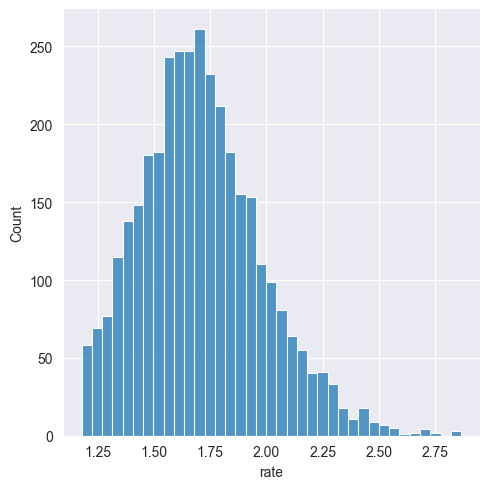

In [9]:
sns.displot(shooter.rate)

# Model

## Model from doc
This uses S(x) to turn each binary variable into -1 vs +1 contrast codes, as used in ANOVA

## Statsmodel version

In [21]:
# Manually do the contrastive coding and NA removal
shooter_na = shooter.dropna().assign(
    s_race=lambda x: x.race.map({'black': 1, 'white': -1}),
    s_object=lambda x: x.object.map({'gun': 1, 'nogun': -1}),
)
subj_model_sm = smf.mixedlm(
    "rate ~ s_race * s_object",
    shooter_na,
    groups=shooter_na['subject']
)
subj_fitted_sm = subj_model_sm.fit()
subj_fitted_sm.summary()

/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:               MixedLM  Dependent Variable:  rate    
No. Observations:    3502     Method:              REML    
No. Groups:          36       Scale:               0.0580  
Min. group size:     94       Log-Likelihood:      -43.7510
Max. group size:     100      Converged:           Yes     
Mean group size:     97.3                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        1.707    0.014 123.264 0.000  1.680  1.734
s_race          -0.001    0.004  -0.259 0.796 -0.009  0.007
s_object         0.093    0.004  22.837 0.000  0.085  0.101
s_race:s_object  0.023    0.004   5.754 0.000  0.015  0.031
Group Var        0.006    0.007                            
===========================================================

"""

## Bambi version

In [10]:
subj_model = bmb.Model(
    "rate ~ S(race) * S(object) + (S(race) * S(object) | subject)",
    shooter,
    dropna=True
)
subj_fitted = subj_model.fit(random_seed=SEED, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

Automatically removing 98/3600 rows from the dataset.


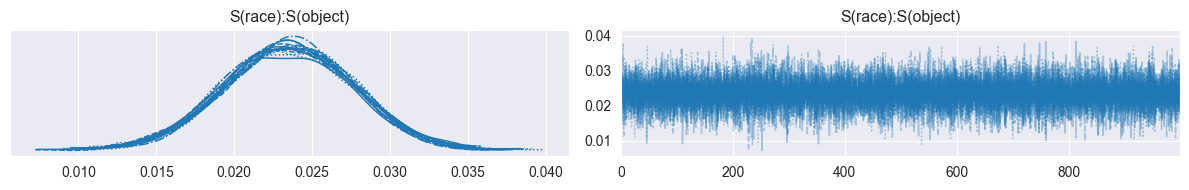

In [11]:
az.plot_trace(subj_fitted, var_names=['S(race):S(object)'])
plt.tight_layout()

In [18]:
az.summary(subj_fitted, var_names=['S(race):S(object)', 'S(race)', 'S(object)'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"S(race):S(object)[black, gun]",0.024,0.004,0.016,0.031,0.0,0.0,28525.0,12015.0,1.0
S(race)[black],-0.001,0.004,-0.009,0.007,0.0,0.0,28685.0,12946.0,1.0
S(object)[gun],0.093,0.006,0.081,0.104,0.0,0.0,8525.0,11006.0,1.0


## Model from doc without using S(x)
Seeing difference in model spec

In [22]:
subj_model_sm_uc = smf.mixedlm(
    "rate ~ race * object",
    shooter_na,
    groups=shooter_na['subject']
)
subj_fitted_sm_uc = subj_model_sm_uc.fit()
subj_fitted_sm_uc.summary()

/Users/mattmcd/Work/Projects/PyBayes/venv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       rate    
No. Observations:        3502          Method:                   REML    
No. Groups:              36            Scale:                    0.0580  
Min. group size:         94            Log-Likelihood:           -40.9784
Max. group size:         100           Converged:                Yes     
Mean group size:         97.3                                            
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      1.823    0.016 117.570 0.000  1.792  1.853
race[T.white]                 -0.045    0.011  -3.908 0.000 -0.067 -0.022
object[T.nogun]               -0.233    0.012 -20.227 0.000 -0.255 -0.210
race[T.white]:object[T.nogun]  0.094    0.016   5.754 0.000  0.062  0.126
Group Var                      0.006    0.007                            
=========================================================================

"""

In [18]:
subj_model2 = bmb.Model(
    "rate ~ race * object + (race * object | subject)",
    shooter,
    dropna=True
)
subj_fitted2 = subj_model2.fit(random_seed=SEED, nuts_sampler='blackjax', chains=n_devices, progressbar=False)

Automatically removing 98/3600 rows from the dataset.


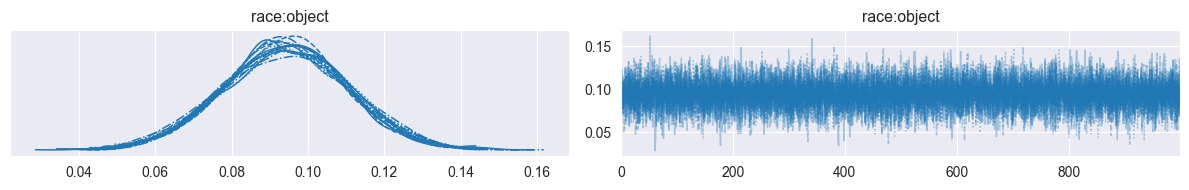

In [19]:
az.plot_trace(subj_fitted2, var_names=['race:object'])
plt.tight_layout()

In [22]:
az.summary(subj_fitted2, var_names=['race:object'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"race:object[white, nogun]",0.094,0.016,0.064,0.126,0.0,0.0,16530.0,12737.0,1.0


In [23]:
subj_fitted2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Model from doc using statsmodels